In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import datetime
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from sklearn.linear_model import BayesianRidge, LinearRegression
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
import cupy as cp
import dask.array as dsa
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
run = [0,1,2,3,4]

coarsen = 16

sn0 = xr.open_mfdataset('tracer/run%i/tracers_00030005.nc' % run[0], decode_times=False)
sn1 = xr.open_mfdataset('tracer/run%i/tracers_00030005.nc' % run[1], decode_times=False)
sn2 = xr.open_mfdataset('tracer/run%i/tracers_00030005.nc' % run[2], decode_times=False)
sn3 = xr.open_mfdataset('tracer/run%i/tracers_00030005.nc' % run[3], decode_times=False)
sn4 = xr.open_mfdataset(['tracer/run4/tracers_00001005.nc'], decode_times=False)

start_time = 30000
duration = sn4.time[-1] - sn4.time[0]
end_time = start_time + duration + 5

# ,'tracer/run4/tracers_00001105.nc','tracer/run4/tracers_00001205.nc','tracer/run4/tracers_00001305.nc'

sn0 = sn0.sel(time=slice(start_time,end_time))
sn1 = sn1.sel(time=slice(start_time,end_time))
sn2 = sn2.sel(time=slice(start_time,end_time))
sn3 = sn3.sel(time=slice(start_time,end_time))

sn4['time'] = sn1['time']

st0 = xr.open_dataset('tracer/run%i/static.nc' % run[0], decode_times=False)
st1 = xr.open_dataset('tracer/run%i/static.nc' % run[1], decode_times=False)
st2 = xr.open_dataset('tracer/run%i/static.nc' % run[2], decode_times=False)
st3 = xr.open_dataset('tracer/run%i/static.nc' % run[3], decode_times=False)
st4 = xr.open_dataset('tracer/run%i/static.nc' % run[4], decode_times=False)

In [4]:
sn4

<xarray.Dataset>
Dimensions:   (time: 20, xh: 1920, yh: 4480, zl: 15)
Coordinates:
  * xh        (xh) float64 0.01562 0.04688 0.07812 0.1094 ... 59.92 59.95 59.98
  * yh        (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * zl        (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time      (time) float64 3.000e+04 3.001e+04 3.002e+04 ... 3.01e+04 3.01e+04
Data variables:
    h         (time, zl, yh, xh) float64 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer01  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer02  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer03  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer04  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer05  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer06  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer07  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer08  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer09  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer10  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer11  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer12  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer13  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer14  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer15  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer16  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer17  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer18  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer19  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
    tracer20  (time, zl, yh, xh) float32 dask.array<chunksize=(20, 15, 4480, 1920), meta=np.ndarray>
Attributes:
    filename:          tracers_00001005.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [5]:
xh = st1.xh.values
yh = st1.yh.values

In [6]:
def coarsen_h(h_fine):
    """It returns the 4 cell average of h when coarsen = 2"""
    v = list(h_fine.shape)
    ly, lx = v[-2], v[-1]
    v[-2] = ly//coarsen
    v[-1] = coarsen
    v.append(lx//coarsen)
    v.append(coarsen)    
    hc_coarse = 0.0*h_fine[...,::coarsen,::coarsen]
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[...,:,:] = hc_coarse[...,:,:] + h_fine[...,j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

In [7]:
def coarsen_h_2(h_fine):
    """It returns the 4 cell average of h when coarsen = 2"""
    v = list(h_fine.shape)
    ly, lx = v[-2], v[-1]
    v[-2] = ly//coarsen
    v[-1] = coarsen
    v.append(lx//coarsen)
    v.append(coarsen)
    
    return (h_fine.reshape(v).sum(axis=-3).sum(axis=-1))/coarsen**2

In [8]:
def accel(fn,var_in,architecture='cpu'):
    dims = var_in.dims[-2:]
#     dims_2 = [dims[0]+'2',dims[1]+'2']
    dims_2 = dims
    if dims == ('yh', 'xh'):
        dims_dict = {dims_2[0]: var_in.shape[-2]//coarsen, dims_2[1]: var_in.shape[-1]//coarsen}
    elif dims == ('yh', 'xq'):
        dims_dict = {dims_2[0]: var_in.shape[-2]//coarsen, dims_2[1]: var_in.shape[-1]//coarsen+1}
    elif dims == ('yq', 'xh'):
        dims_dict = {dims_2[0]: var_in.shape[-2]//coarsen+1, dims_2[1]: var_in.shape[-1]//coarsen}
    if architecture=='gpu':
        var_gpu = var_in.copy()
        var_gpu.data = var_gpu.data.map_blocks(cp.asarray)
        var_final_gpu = xr.apply_ufunc(fn,var_gpu,input_core_dims=[dims],output_core_dims=[dims_2],exclude_dims=set(dims),output_dtypes=[var_in.dtype],dask='parallelized',output_sizes=dims_dict)
        var_final_gpu[dims_2[0]] = yh
        var_final_gpu[dims_2[1]] = xh
        return var_final_gpu.data.map_blocks(cp.asnumpy)
    if architecture=='cpu':
        var_final_cpu = xr.apply_ufunc(fn,var_in,input_core_dims=[dims],output_core_dims=[dims_2],exclude_dims=set(dims),output_dtypes=[var_in.dtype],dask='parallelized',output_sizes=dims_dict)
        var_final_cpu[dims_2[0]] = yh
        var_final_cpu[dims_2[1]] = xh
        return var_final_cpu

In [9]:
%time h3 = accel(coarsen_h_2,sn4.h,architecture='gpu')
%time h4 = accel(coarsen_h_2,sn4.h,architecture='cpu')

CPU times: user 73.8 ms, sys: 197 ms, total: 271 ms
Wall time: 271 ms
CPU times: user 2.63 ms, sys: 0 ns, total: 2.63 ms
Wall time: 2.64 ms


In [10]:
sn5 = xr.open_mfdataset('run33/snapshots_00001005.nc', decode_times=False)

%time h1 = accel(coarsen_h,sn5.h,architecture='cpu')
%time h2 = accel(coarsen_h_2,sn5.h,architecture='cpu')

CPU times: user 6.13 ms, sys: 12 µs, total: 6.14 ms
Wall time: 6.09 ms
CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.58 ms


CPU times: user 26.4 s, sys: 10.7 s, total: 37.1 s
Wall time: 50.9 s
CPU times: user 10.3 s, sys: 9.07 s, total: 19.4 s
Wall time: 55.2 s
CPU times: user 35.3 s, sys: 14.7 s, total: 50 s
Wall time: 1min 16s


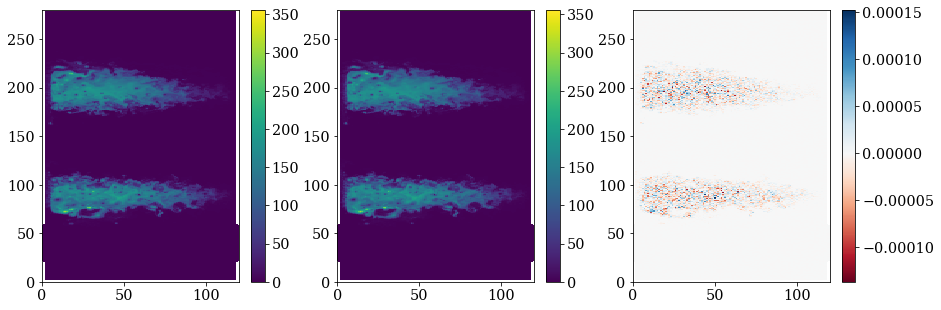

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
%time plt.pcolormesh(h1[0,0])
plt.colorbar()

plt.subplot(1,3,2)
%time plt.pcolormesh(h2[0,0])
plt.colorbar()

plt.subplot(1,3,3)
%time plt.pcolormesh((h2[0,0]-h1[0,0]).values,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.colorbar()

In [12]:
h1

<xarray.DataArray 'h' (time: 20, zl: 15, yh: 280, xh: 120)>
dask.array<transpose, shape=(20, 15, 280, 120), dtype=float32, chunksize=(20, 15, 280, 120), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 1.005e+03 1.01e+03 1.015e+03 ... 1.095e+03 1.1e+03
  * yh       (yh) float64 -69.75 -69.25 -68.75 -68.25 ... 68.75 69.25 69.75
  * xh       (xh) float64 0.25 0.75 1.25 1.75 2.25 ... 58.25 58.75 59.25 59.75

In [13]:
tracers = list(sn1.data_vars)

In [14]:
E = np.zeros((4,len(tracers)))

In [15]:
E.shape

(4, 21)

Compare time- and depth- averaged tracer: 
1. $<t>$ = $<ht>$/$<h>$ where $<>$ represents a 5-day time-average
2. t = sum(ht)/sum(h) where the sum is over layers. 

In [18]:
for i in range(1,len(tracers)):
    print(i)
    # time-mean tracer and thickness
    ht = (sn4[tracers[i]]*sn4.h).coarsen(time=5, boundary="trim").mean()
    h = sn4.h.coarsen(time=5, boundary="trim").mean()
    t = ht/h
    # depth-averaged tracer
    ht = (t*h).sum(dim='zl')
    h = h.sum(dim='zl')
    t_dep = ht/h
    
    # coarsen 1/32 degree data
    t_ref = accel(coarsen_h,t_dep,architecture='cpu')
    %time t_ref = t_ref.values
    
    # time-mean tracer and thickness - run 0
    ht = (sn0[tracers[i]]*sn0.h).coarsen(time=5, boundary="trim").mean()
    h = sn0.h.coarsen(time=5, boundary="trim").mean()
    t = ht/h
    # depth-averaged tracer
    ht = (t*h).sum(dim='zl')
    h = h.sum(dim='zl')
    t0 = (ht/h).values
    
    # time-mean tracer and thickness - run 1
    ht = (sn1[tracers[i]]*sn1.h).coarsen(time=5, boundary="trim").mean()
    h = sn1.h.coarsen(time=5, boundary="trim").mean()
    t = ht/h
    # depth-averaged tracer
    ht = (t*h).sum(dim='zl')
    h = h.sum(dim='zl')
    t1 = (ht/h).values
    
    # time-mean tracer and thickness - run 2
    ht = (sn2[tracers[i]]*sn2.h).coarsen(time=5, boundary="trim").mean()
    h = sn2.h.coarsen(time=5, boundary="trim").mean()
    t = ht/h
    # depth-averaged tracer
    ht = (t*h).sum(dim='zl')
    h = h.sum(dim='zl')
    t2 = (ht/h).values
    
    # time-mean tracer and thickness - run 3
    ht = (sn3[tracers[i]]*sn3.h).coarsen(time=5, boundary="trim").mean()
    h = sn3.h.coarsen(time=5, boundary="trim").mean()
    t = ht/h
    # depth-averaged tracer
    ht = (t*h).sum(dim='zl')
    h = h.sum(dim='zl')
    t3 = (ht/h).values

    %time E[:, i] = E[:,i] + [np.nansum(t0-t_ref)**2, np.nansum(t1-t_ref)**2, np.nansum(t2-t_ref)**2, np.nansum(t3-t_ref)**2]

1
CPU times: user 1min 24s, sys: 53 s, total: 2min 17s
Wall time: 3min 55s
CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 2.24 ms
2
CPU times: user 1min 27s, sys: 53 s, total: 2min 20s
Wall time: 4min 1s
CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 2.47 ms
3
CPU times: user 1min 28s, sys: 52.5 s, total: 2min 21s
Wall time: 3min 57s
CPU times: user 2.07 ms, sys: 39 µs, total: 2.11 ms
Wall time: 2.12 ms
4
CPU times: user 1min 26s, sys: 53.8 s, total: 2min 20s
Wall time: 3min 52s
CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 2.48 ms
5
CPU times: user 1min 26s, sys: 52.6 s, total: 2min 19s
Wall time: 3min 48s
CPU times: user 2.28 ms, sys: 0 ns, total: 2.28 ms
Wall time: 2.29 ms
6
CPU times: user 1min 24s, sys: 52.8 s, total: 2min 17s
Wall time: 3min 50s
CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 2.24 ms
7
CPU times: user 1min 24s, sys: 53 s, total: 2min 17s
Wall time: 3min 51s
CPU times: user 2.35 ms, sys: 0 ns, total: 2.35

In [20]:
KHTR = [0.0, 1050.0, 2100.0, 4200.0]

In [21]:
n = 10
colors = plt.cm.gist_rainbow(np.linspace(0,1,n))

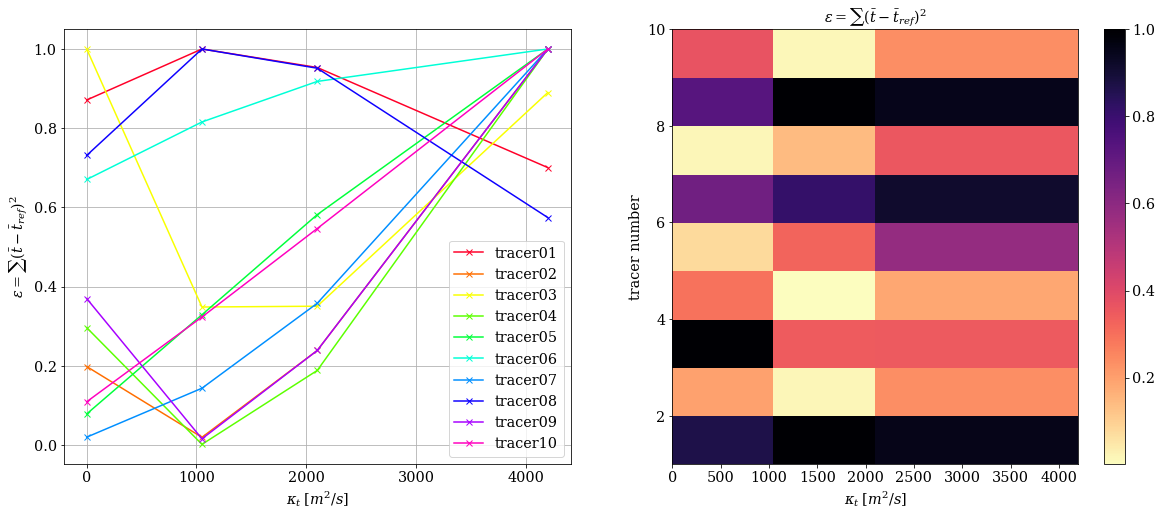

In [22]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

for i in range(1,11):
    plt.plot(KHTR,E[:,i]/np.max(E[:,i]),'x-',color=colors[(i-1)])
plt.xlabel(r'$\kappa_{t}\;[m^2/s]$')
plt.ylabel(r'$\epsilon=\sum (\bar{t}-\bar{t}_{ref})^2$')
plt.grid()
plt.legend(tracers[1:])

plt.subplot(1,2,2)
plt.pcolormesh(KHTR,np.arange(1,11,1),E[:,1:11].T/np.max(E[:,1:11],axis=0).reshape(10,1),cmap='magma_r')
plt.xlabel(r'$\kappa_{t}\;[m^2/s]$')
plt.ylabel('tracer number')
plt.title(r'$\epsilon=\sum (\bar{t}-\bar{t}_{ref})^2$')
plt.colorbar()
plt.yticks(np.arange(2,12,2))

plt.savefig('tracers_error.png', dpi=200,bbox_inches='tight',pad_inches=0)

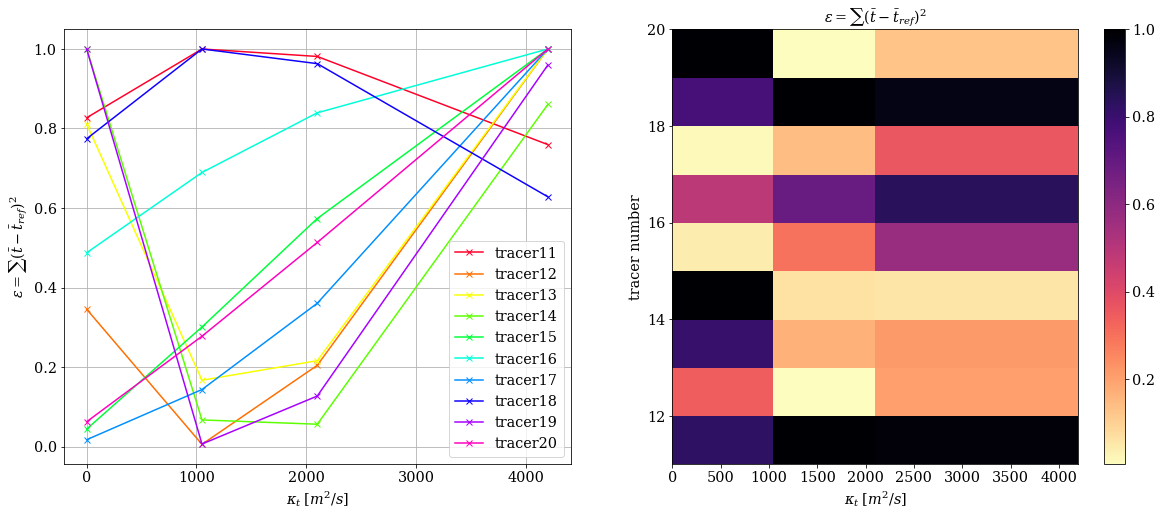

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

for i in range(11,21):
    plt.plot(KHTR,E[:,i]/np.max(E[:,i]),'x-',color=colors[(i-11)])
plt.xlabel(r'$\kappa_{t}\;[m^2/s]$')
plt.ylabel(r'$\epsilon=\sum (\bar{t}-\bar{t}_{ref})^2$')
plt.grid()
plt.legend(tracers[11:])

plt.subplot(1,2,2)
plt.pcolormesh(KHTR,np.arange(11,21,1),E[:,11:21].T/np.max(E[:,11:21],axis=0).reshape(10,1),cmap='magma_r')
plt.xlabel(r'$\kappa_{t}\;[m^2/s]$')
plt.ylabel('tracer number')
plt.title(r'$\epsilon=\sum (\bar{t}-\bar{t}_{ref})^2$')
plt.colorbar()
plt.yticks(np.arange(12,22,2))

plt.savefig('tracers_error.png', dpi=200,bbox_inches='tight',pad_inches=0)